In [1]:
import sqlalchemy as db
import numpy as np
import pandas as pd
import pyodbc
import yaml
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import umap
import umap.plot

# custom functions imports
import MS_Functions as f

C:\Users\Marija\anaconda3\envs\process-optimization\lib\site-packages\umap\__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [2]:
db_config_file_path = '../db_config.yml'
db_config = yaml.safe_load(open(db_config_file_path))

In [3]:
engine = db.create_engine('{DB_DRIVER}://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}?driver={DB_ODBC_DRIVER}'.format(**db_config))

In [4]:
sql = """
SELECT 
ps.[PRIMARY] , 
ps.ID ,
ps.INSDATE,
ps.MA_NR ,
ps.WSG_ID ,
ps.WZS_ID ,
ps.WZD_ID ,
ps.KOR_ID ,
ps.ST_ID ,
ps.AT_ID ,
ps.PUS_ID ,
IMAX_R,
IMAX_L,
IRMS_R,
IRMS_L,
IINT_R,
IINT_L,
IMAX_R_abHUB2,
IRMS_R_abHUB2,
IINT_R_abHUB2,
POSI_X,
POSI_Y,
POSI_Y_L,
POSI_Z,
ORD1_R,
ORD2_R,
ORDz1_I_R,
ORDz2_I_R,
ORDz3_I_R,
ORDsum_R,
ORD1_L,
ORD2_L,
ORDz1_I_L,
ORDz2_I_L,
ORDz3_I_L,
ORDsum_L,
ORDb_aR,
ORDz1_aR,
ORDz2_aR,
ORDz3_aR,
ORDsum_aR,
ORDAmax_aR,
ORDFmax_aR,
ORDb_aL,
ORDz1_aL,
ORDz2_aL,
ORDz3_aL,
ORDsum_aL,
ORDAmax_aL,
ORDFmax_aL,
AXIS_C_ACTIVE,
FORCE_FAKTOR,
APM_SCHL_Aktiv,
SCHLEIFZEIT,
IRMS_V,
IMAX_Xanfahrt,
IINT_V,
VORSTUFE_AKTIV,
IMAX_V,
IINTOFF_R,
NIO,
CASE WHEN NIO=0 THEN 0 ELSE 1 END NIO_GROUP
FROM dbo.prozessmessung_schleifen ps 
WHERE MA_NR IN (78635, 78494, 78459, 78583)
AND WARM = 0
AND TEACH_ACTIVE = 0
AND READY = 1;
"""

In [5]:
with engine.connect() as conn:
    df = pd.read_sql(sql=sql, con=conn)
df = df.set_index('PRIMARY')

In [6]:
df_sc_gn_file = '../data/interim/78494_sharpening_cycle_gear_num_202101201336.csv'

In [7]:
df_sc_gn = pd.read_csv(df_sc_gn_file).set_index('PRIMARY')

In [8]:
df_cleaned = df.loc[(df['WSG_ID']==1)
                    & (df['WZD_ID']==1)
                    & (df['ST_ID']==1)
                    & (df['AT_ID']==1)
                    & (df['MA_NR']==78494), :]

df_cleaned = df_cleaned.join(df_sc_gn[['wheel_num', 'sharpening_cycle', 'gear_number']])
df_cleaned = f.clean_df(df_cleaned)
df_cleaned = df_cleaned.reset_index()
df_cleaned.shape

dropped 7 columns
dropped 1 rows


(248185, 58)

In [36]:
df_cleaned.columns

Index(['PRIMARY', 'ID', 'INSDATE', 'MA_NR', 'WSG_ID', 'WZS_ID', 'WZD_ID',
       'KOR_ID', 'ST_ID', 'AT_ID', 'PUS_ID', 'IMAX_R', 'IMAX_L', 'IRMS_R',
       'IRMS_L', 'IINT_R', 'IINT_L', 'IMAX_R_abHUB2', 'IRMS_R_abHUB2',
       'IINT_R_abHUB2', 'POSI_X', 'POSI_Y', 'POSI_Y_L', 'POSI_Z', 'ORD1_R',
       'ORD2_R', 'ORDz1_I_R', 'ORDz2_I_R', 'ORDz3_I_R', 'ORDsum_R', 'ORD1_L',
       'ORD2_L', 'ORDz1_I_L', 'ORDz2_I_L', 'ORDz3_I_L', 'ORDsum_L', 'ORDb_aR',
       'ORDz1_aR', 'ORDz2_aR', 'ORDz3_aR', 'ORDsum_aR', 'ORDAmax_aR',
       'ORDFmax_aR', 'ORDb_aL', 'ORDz1_aL', 'ORDz2_aL', 'ORDz3_aL',
       'ORDsum_aL', 'ORDAmax_aL', 'ORDFmax_aL', 'AXIS_C_ACTIVE',
       'FORCE_FAKTOR', 'APM_SCHL_Aktiv', 'NIO', 'NIO_GROUP', 'wheel_num',
       'sharpening_cycle', 'gear_number'],
      dtype='object')

In [9]:
df_model = df_cleaned.drop(['MA_NR', 'INSDATE','PRIMARY', 'ID', 'WSG_ID', 'WZS_ID', 'WZD_ID', 'KOR_ID', 'ST_ID', 'AT_ID', 'PUS_ID', 'NIO', 'NIO_GROUP'], axis=1)

In [15]:
df_model.columns

Index(['IMAX_R', 'IMAX_L', 'IRMS_R', 'IRMS_L', 'IINT_R', 'IINT_L',
       'IMAX_R_abHUB2', 'IRMS_R_abHUB2', 'IINT_R_abHUB2', 'POSI_X', 'POSI_Y',
       'POSI_Y_L', 'POSI_Z', 'ORD1_R', 'ORD2_R', 'ORDz1_I_R', 'ORDz2_I_R',
       'ORDz3_I_R', 'ORDsum_R', 'ORD1_L', 'ORD2_L', 'ORDz1_I_L', 'ORDz2_I_L',
       'ORDz3_I_L', 'ORDsum_L', 'ORDb_aR', 'ORDz1_aR', 'ORDz2_aR', 'ORDz3_aR',
       'ORDsum_aR', 'ORDAmax_aR', 'ORDFmax_aR', 'ORDb_aL', 'ORDz1_aL',
       'ORDz2_aL', 'ORDz3_aL', 'ORDsum_aL', 'ORDAmax_aL', 'ORDFmax_aL',
       'AXIS_C_ACTIVE', 'FORCE_FAKTOR', 'APM_SCHL_Aktiv', 'wheel_num',
       'sharpening_cycle', 'gear_number'],
      dtype='object')

## IsolationForest

In [21]:
if_default = IsolationForest()

In [22]:
labels = pd.DataFrame(if_default.fit_predict(df_model))

In [29]:
labels.head()

0
0  1
1  1
2  1
3  1
4  1

In [23]:
labels.value_counts()

 1    227398
-1     20787
dtype: int64

In [24]:
df_cleaned['NIO_GROUP'].value_counts()

0    196661
1     51524
Name: NIO_GROUP, dtype: int64

In [43]:
pd.crosstab(df_cleaned['NIO_GROUP'], labels[0], colnames=['IsolationForest Labels'])

IsolationForest Labels     -1       1
NIO_GROUP                            
0                        8433  188228
1                       12354   39170

<AxesSubplot:xlabel='POSI_Y', ylabel='gear_number'>

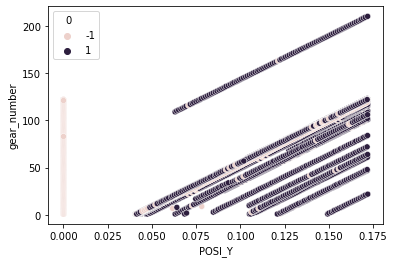

In [44]:
sns.scatterplot(x=df_cleaned['POSI_Y'], y=df_cleaned['gear_number'], hue=labels[0])

In [155]:
df_labeled = df_cleaned.copy()
df_labeled['ifor_labels'] = labels

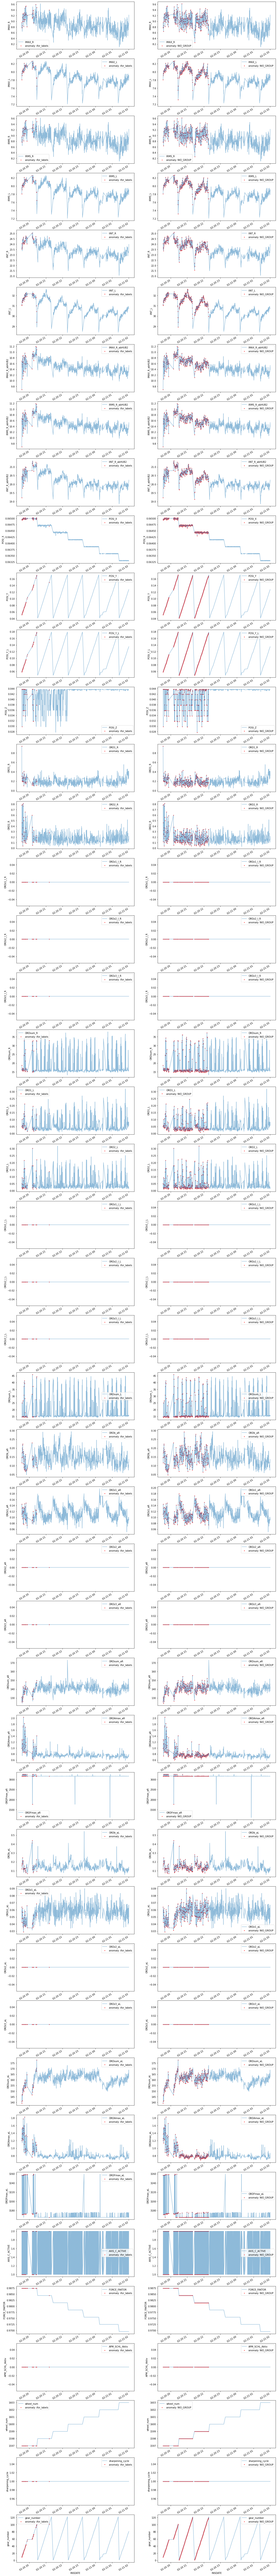

In [327]:
plot_time_series(df_labeled, columns=list(df_model.columns.values), anomaly_columns=['ifor_labels', 'NIO_GROUP'], anomaly_values=[-1, 1], start_date='2020-02-20 19:00', end_date='2020-02-21 02:00')

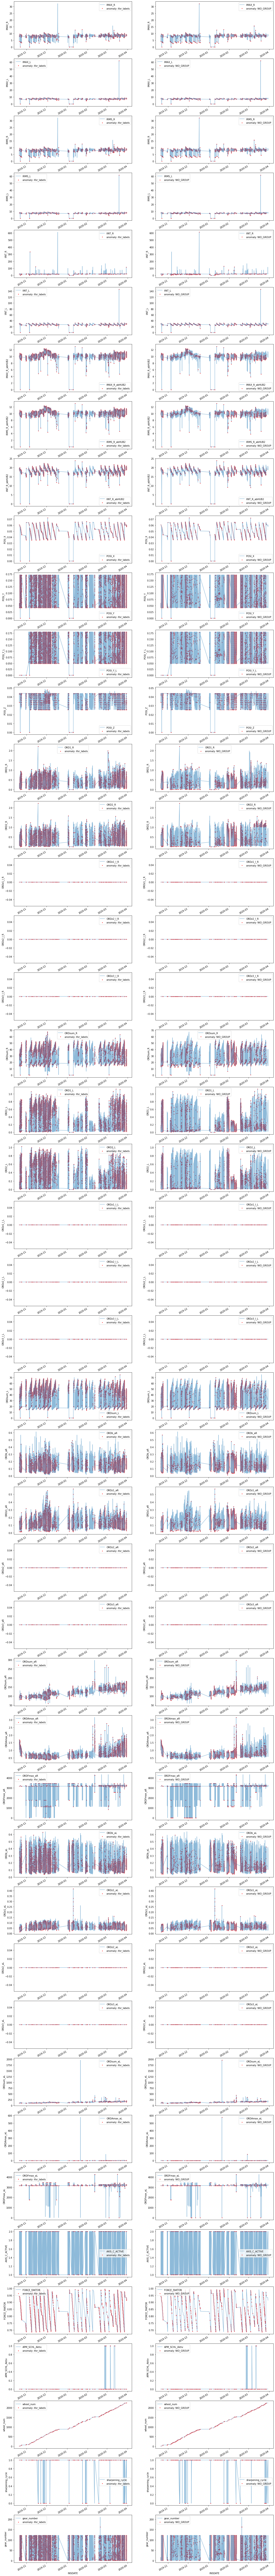

In [328]:
plot_time_series(df_labeled, columns=list(df_model.columns.values), anomaly_columns=['ifor_labels', 'NIO_GROUP'], anomaly_values=[-1, 1])

### Specify 5% contamination for IsolationForest

In [356]:
if_5_pct = IsolationForest(contamination=0.05)

In [357]:
lables_5_pct = pd.DataFrame(if_5_pct.fit_predict(df_model))

In [358]:
df_labeled['ifor_5pct'] = lables_5_pct[0]

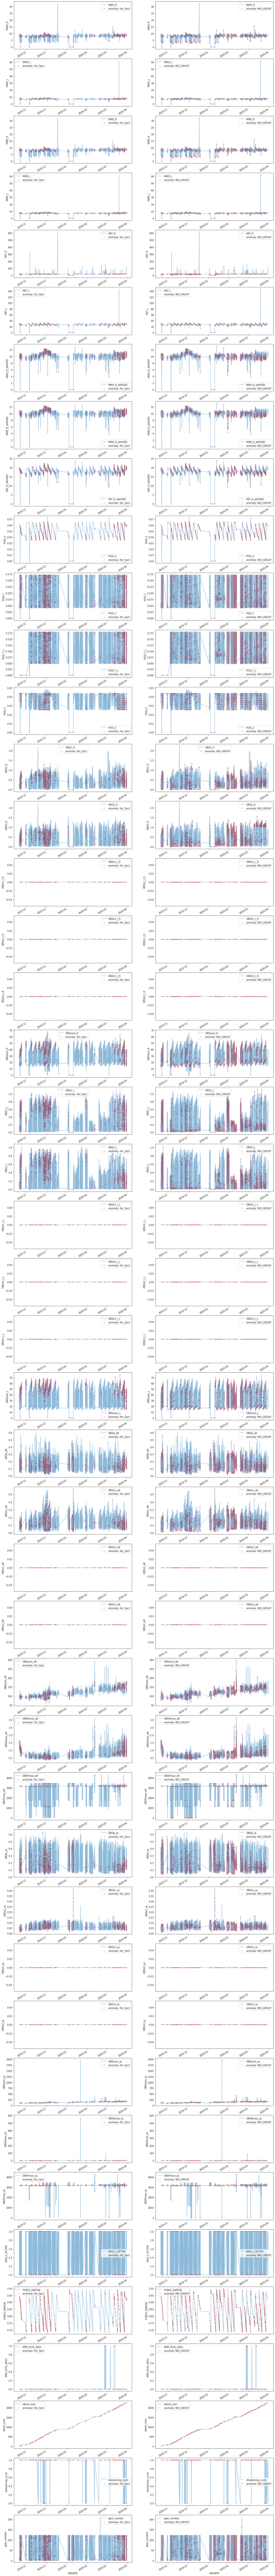

In [359]:
plot_time_series(df_labeled, columns=list(df_model.columns.values), anomaly_columns=['ifor_5pct', 'NIO_GROUP'], anomaly_values=[-1, 1])

## Plot UMAP with color by NIO, and IsolationForest Labels

In [10]:
reducer = umap.UMAP()

In [11]:
sc = StandardScaler()

In [12]:
pipeline = Pipeline(steps=[('scaler', sc),
                          ('reducer', reducer)
                          ])

In [373]:
embedding = pipeline.fit_transform(df_model)

C:\Users\Marija\anaconda3\envs\process-optimization\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Some columns are all zeros, need to remove

In [14]:
min_max = df_model.agg(['min', 'max']).T

In [15]:
drop_cols = list(min_max.loc[(min_max['min'] == 0) & (min_max['max']==0)].index.values)

In [16]:
df_model_reduced = df_model.drop(drop_cols, axis=1)

In [17]:
print(f'dropped {df_model.shape[1] - df_model_reduced.shape[1]} columns')

dropped 10 columns


In [18]:
df_model_reduced = df_model_reduced.drop(['sharpening_cycle', 'wheel_num', 'gear_number', 'AXIS_C_ACTIVE', 'APM_SCHL_Aktiv'], axis=1)

In [19]:
(df_model_reduced == 0).all(axis=0)

IMAX_R           False
IMAX_L           False
IRMS_R           False
IRMS_L           False
IINT_R           False
IINT_L           False
IMAX_R_abHUB2    False
IRMS_R_abHUB2    False
IINT_R_abHUB2    False
POSI_X           False
POSI_Y           False
POSI_Y_L         False
POSI_Z           False
ORD1_R           False
ORD2_R           False
ORDsum_R         False
ORD1_L           False
ORD2_L           False
ORDsum_L         False
ORDb_aR          False
ORDz1_aR         False
ORDsum_aR        False
ORDAmax_aR       False
ORDFmax_aR       False
ORDb_aL          False
ORDz1_aL         False
ORDsum_aL        False
ORDAmax_aL       False
ORDFmax_aL       False
FORCE_FAKTOR     False
dtype: bool

In [21]:
reducer_default = umap.UMAP()
sc_default = StandardScaler()
pipeline_default = Pipeline(steps=[('scale', sc_default),
                                   ('reduce', reducer_default)])

In [476]:
embeddings_default = pipeline_default.fit_transform(df_model_reduced)
%time

C:\Users\Marija\anaconda3\envs\process-optimization\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Wall time: 2.26 ms


In [477]:
disconnected_points = umap.utils.disconnected_vertices(reducer_default)

In [25]:
sc_cos = StandardScaler()
reducer_cosine = umap.UMAP(metric='cosine')
reducer_pipeline = Pipeline(steps=[('scale', sc_cos), 
                                   ('reduce', reducer_cosine)])
reducer_pipeline.fit(df_model_reduced)

Pipeline(steps=[('scale', StandardScaler()),
                ('reduce',
                 UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0,
                      metric='cosine'))])

<AxesSubplot:>

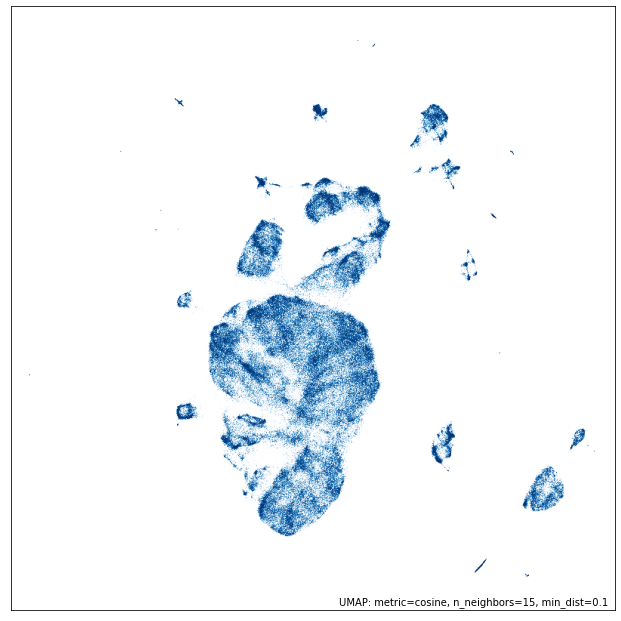

In [26]:
umap.plot.points(reducer_cosine)

In [27]:
def nio_labels(nio_series):
    nio_df = pd.DataFrame(nio_series.astype(str).str.rjust(10,'0').apply(lambda x: [i for i in x] if len(x)==10 else None).apply(pd.Series))
    nio_df.columns = ['1,000,000,000', '100,000,000', '10,000,000', '1,000,000', '100,000', '10,000', '1,000', '100', '10', '1']
    return nio_df

In [29]:
nio_df = nio_labels(df_cleaned['NIO'])

Text(0.5, 1.0, 'MA_NR 78,494, Error codes 1, 10, 1000')

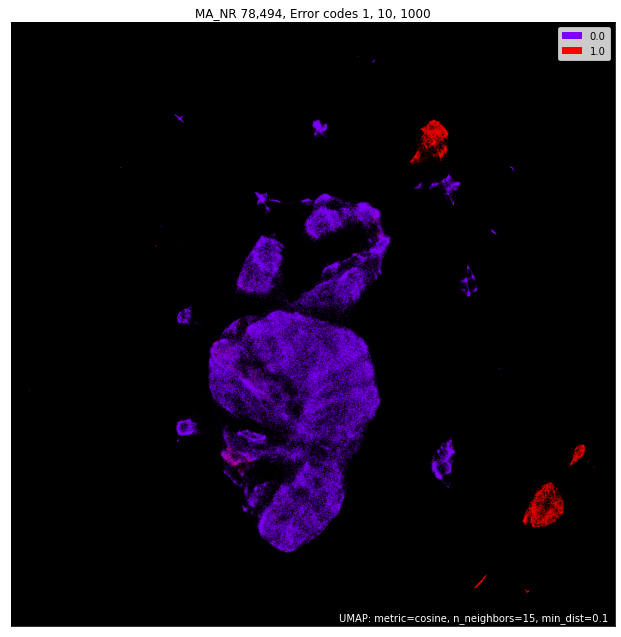

In [55]:
ax = umap.plot.points(reducer_cosine, labels=nio_df[['1', '10', '1,000']].max(axis=1), theme='fire')
ax.set_title('MA_NR 78,494, Error codes 1, 10, 1000')

In [30]:
nio_df.head()

1,000,000,000 100,000,000 10,000,000 1,000,000 100,000 10,000 1,000 100 10  \
0             0           0          1         0       1      0     1   0  0   
1             0           0          1         0       0      0     1   0  0   
2             0           0          1         0       1      0     0   0  0   
3             0           0          1         0       1      0     0   0  0   
4             0           0          1         0       1      0     0   0  0   

   1  
0  0  
1  0  
2  0  
3  0  
4  0

In [35]:
df_cleaned['NIO'].value_counts()

0           196661
11110000     24191
1000          9771
10            5461
11110100      2930
110           2829
10100000      1318
11110110       964
10101000       898
100000         517
10000          508
11110010       363
10000000       356
1000000        300
10110000       287
100            247
11110111       156
101000          87
11100000        74
10010000        71
10001000        51
100110          26
11000000        21
1110111         16
100010          13
110000          12
11010111        10
11010000        10
1110000          9
100100           7
1010000          5
1010             5
10011000         2
1100000          2
1110             2
10110            1
1100             1
1010111          1
11               1
1000100          1
Name: NIO, dtype: int64

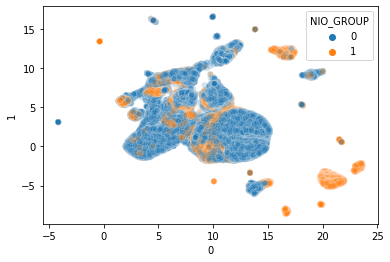

In [516]:
sns.scatterplot(x=embeddings_cosine[0], y=embeddings_cosine[1], hue=df_labeled['NIO_GROUP'], alpha=0.2);

In [513]:
df_labeled['NIO'].loc[(embeddings_cosine[0]>18)&(embeddings_cosine[1]<0)].value_counts()

1000        9664
101000        16
10101000       1
Name: NIO, dtype: int64

In [511]:
df_labeled['NIO'].loc[(embeddings_cosine[0]>15)&(embeddings_cosine[0]<20)&(embeddings_cosine[1]>10)].value_counts()

10          3440
110         2323
10100000       9
10000000       7
0              7
10101000       3
10001000       2
10010000       1
11000000       1
Name: NIO, dtype: int64

In [501]:
df_labeled['NIO'].value_counts()

0           196661
11110000     24191
1000          9771
10            5461
11110100      2930
110           2829
10100000      1318
11110110       964
10101000       898
100000         517
10000          508
11110010       363
10000000       356
1000000        300
10110000       287
100            247
11110111       156
101000          87
11100000        74
10010000        71
10001000        51
100110          26
11000000        21
1110111         16
100010          13
110000          12
11010111        10
11010000        10
1110000          9
100100           7
1010000          5
1010             5
10011000         2
1100000          2
1110             2
10110            1
1100             1
1010111          1
11               1
1000100          1
Name: NIO, dtype: int64